In [128]:
%matplotlib inline
import numpy as np
from progress.bar import Bar
from matrix_neural_net import Network
import matplotlib.pyplot as plt
import mnist
from tqdm import tqdm_notebook , tnrange
from IPython import display
from IPython.display import clear_output


In [44]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [65]:
def one_hot_encode(val):
    r = np.zeros(10)
    r[int(val)] = 1
    return r

In [68]:
temp_y_train = np.array([one_hot_encode(i) for i in y_train])
temp_y_test = np.array([one_hot_encode(i) for i in y_test])

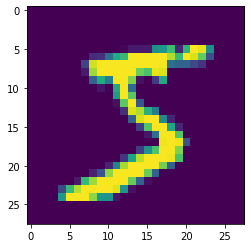

In [70]:
plt.imshow(x_train[0])

In [73]:
len(x_train[0].flatten())

784

In [152]:
network = Network(
    shape=[784, 200,80, 10], 
    activation = 'sigmoid', output_activation="sigmoid",
    learning_rate= 0.01
)

In [120]:
guess = network.forward_pass(x_train[0].flatten())

In [121]:
guess

array([-0.98481186,  0.9999754 ,  0.99992967,  0.99954353, -0.54675443,
       -0.79374128,  0.765079  , -0.9856365 ,  0.88629248,  0.99011413])

In [93]:
def interpret(result):
    return np.argmax(result)

In [122]:
interpret(guess)

1

In [96]:
network.backward_pass(
    network_input = x_train[0].flatten(),
    network_output = guess, 
    expected_output = temp_y_train[0]
)

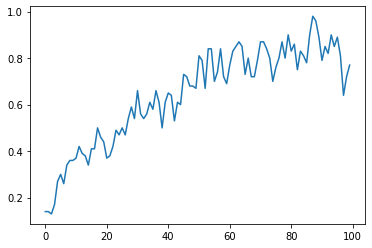

In [153]:
def train_test_network(epoch, train_start, train_end, test_start, test_end):
    
    #for i in tnrange(train_start, train_end, desc = 'Training epoch %i'% epoch):
    for i in range(train_start, train_end):

        output = network.forward_pass(x_train[i].flatten())
        network.backward_pass(
            network_input = x_train[i].flatten(),
            network_output = output,
            expected_output = temp_y_train[i]
        )

    
    correct= 0
    for i in range(test_start, test_end):
    #for i in tnrange(test_start, test_end, desc='Testing epoch %i'% epoch):
        
        output = network.forward_pass(x_test[i].flatten())
        
        if interpret(output) == interpret(temp_y_test[i]):
            correct += 1
    accuracy = correct /(test_end - test_start)
    return accuracy
    
accuracies = []
num_epochs = 100
plt.figure()
for i in tnrange(num_epochs, desc="Training"):
    
    train_start = i * int(len(x_train)/num_epochs)
    train_end = (i+1) * int(len(x_train)/num_epochs)
    test_start = i * int(len(x_test)/num_epochs)
    test_end = (i+1) * int(len(x_test)/num_epochs)
    
    acc = train_test_network(
        i,train_start, train_end, 
        test_start, test_end
    )
    accuracies.append(acc)

plt.plot(accuracies)
plt.show()


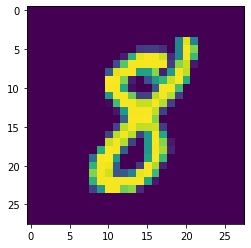

In [134]:
plt.imshow(x_train[41])

In [140]:
(network.forward_pass(x_train[41].flatten()))

array([-0.99769569, -0.99999842, -0.9999271 , -0.47610753, -0.99967914,
       -0.9999308 , -0.99978127, -0.99752775, -0.99930675, -0.99991466])

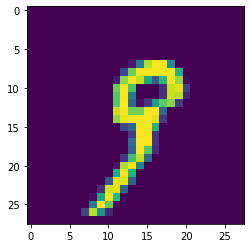

In [130]:
plt.figure()

for i in range(10):
    plt.imshow(x_train[10+i])
    plt.show()
    fig.canvas.draw()
    time.sleep(1)
    clear_output(wait=True)
    
    
